In [ ]:
!rm -rf pytorch_utils
!git clone https://github.com/rahuldsce/pytorch_utils.git

In [66]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [67]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from pytorch_utils import dataset
train, test = dataset.cifar10()

In [70]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [71]:
class Net(nn.Module):
  def conv_block (self, in_channels, out_channels, kernel_size, padding = 1) :
        return nn.Sequential(
              nn.Conv2d (in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, bias = False),
              nn.ReLU(),
              nn.BatchNorm2d(out_channels),
              nn.Dropout(0.1))

  def trans_block (self, in_channels, out_channels):
    return nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 1, padding = 0, bias = False))

  def out_block(self, in_channels, kernel_size = 1):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=10, kernel_size = kernel_size, padding = 0, bias = False))

  def __init__(self, opts=[]):
        super(Net, self).__init__()
        self.conv1 = self.conv_block(3, 16, 3) #32
        self.conv2 = self.conv_block(16, 32, 3) #32
        self.trans1 = self.trans_block(32, 16) #32
        self.conv3 = self.conv_block(16, 16, 3) #16
        self.conv4 = self.conv_block(16, 32, 3) #16
        self.conv5 = self.conv_block(32, 32, 3) #16
        self.trans2 = self.trans_block(32, 16) #16
        self.conv6 = self.conv_block(16, 16, 3) #8
        self.conv7 = self.conv_block(16, 32, 3) #8
        self.conv8 = self.conv_block(32, 32, 3) #8
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=8))
        self.out = self.out_block(32, 1)
        self.pool = nn.MaxPool2d(2, 2)


  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.trans1(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.trans2(x)
      x = self.conv6(x)
      x = self.conv7(x)
      x = self.conv8(x)
      x = self.gap(x)
      x = self.out(x)
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)

In [72]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 16, 16, 16]             512
           Conv2d-11           [-1, 16, 16, 16]           2,304
             ReLU-12           [-1, 16, 16, 16]               0
      BatchNorm2d-13           [-1, 16, 16, 16]              32
          Dropout-14           [-1, 16,

In [80]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [81]:
import torch.optim as optim
import torch.nn as nn

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
EPOCHS = 10

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.2822734117507935 Batch_id=390 Accuracy=52.64: 100%|██████████| 391/391 [00:24<00:00, 15.94it/s]



Test set: Average loss: 1.2978, Accuracy: 5233/10000 (52.33%)

EPOCH: 1


Loss=1.2599891424179077 Batch_id=390 Accuracy=58.70: 100%|██████████| 391/391 [00:24<00:00, 16.10it/s]



Test set: Average loss: 1.1885, Accuracy: 5778/10000 (57.78%)

EPOCH: 2


Loss=1.005330204963684 Batch_id=390 Accuracy=62.27: 100%|██████████| 391/391 [00:24<00:00, 16.09it/s]



Test set: Average loss: 1.0021, Accuracy: 6284/10000 (62.84%)

EPOCH: 3


Loss=1.2171412706375122 Batch_id=390 Accuracy=64.90: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s]



Test set: Average loss: 0.9645, Accuracy: 6566/10000 (65.66%)

EPOCH: 4


Loss=1.025998830795288 Batch_id=390 Accuracy=66.85: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s]



Test set: Average loss: 0.9176, Accuracy: 6731/10000 (67.31%)

EPOCH: 5


Loss=1.0125988721847534 Batch_id=390 Accuracy=68.65: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]



Test set: Average loss: 0.8622, Accuracy: 6983/10000 (69.83%)

EPOCH: 6


Loss=0.6855047941207886 Batch_id=390 Accuracy=70.07: 100%|██████████| 391/391 [00:24<00:00, 16.03it/s]



Test set: Average loss: 0.8729, Accuracy: 7017/10000 (70.17%)

EPOCH: 7


Loss=0.8864132761955261 Batch_id=390 Accuracy=70.72: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]



Test set: Average loss: 0.8347, Accuracy: 7095/10000 (70.95%)

EPOCH: 8


Loss=0.8731245994567871 Batch_id=390 Accuracy=71.56: 100%|██████████| 391/391 [00:24<00:00, 15.81it/s]



Test set: Average loss: 0.8777, Accuracy: 6961/10000 (69.61%)

EPOCH: 9


Loss=0.7246647477149963 Batch_id=390 Accuracy=72.29: 100%|██████████| 391/391 [00:24<00:00, 15.82it/s]



Test set: Average loss: 0.7778, Accuracy: 7320/10000 (73.20%)



In [84]:
torch.save(model.state_dict(), f"./cifar_10_bn.pth")

In [152]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_misclassified_images_from_model(model, model_path, data_loader, class_labels, image_count):
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  correct = 0
  figure = plt.figure(figsize=(15,15))
  count = 0
  with torch.no_grad():
      for data, target in data_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

          for idx in range(len(pred)):
            i_pred, i_act = pred[idx], target[idx]
            if i_pred != i_act:
                annotation = "Actual: %s, Predicted: %s" % (class_labels[i_act], class_labels[i_pred])
                count += 1
                plt.subplot(5, 2, count)
                plt.axis('off')
                imshow(data[idx].cpu())
                plt.annotate(annotation, xy=(0,0), xytext=(0,-1.2), fontsize=13)
            if count == image_count:
                return

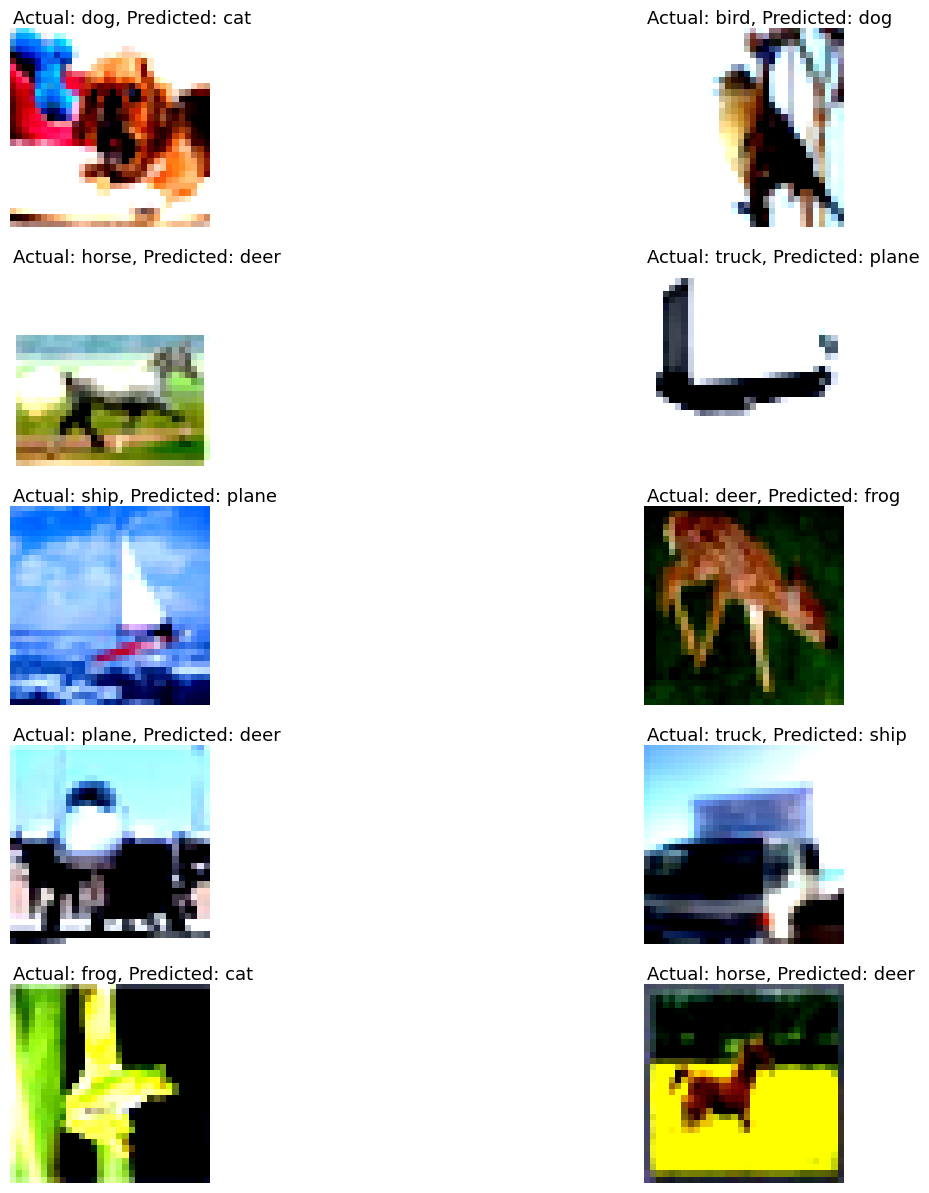

In [153]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_misclassified_images_from_model(model, "./cifar_10_bn.pth", test_loader, classes, 10)